<a href="https://colab.research.google.com/github/yashikart/Blood-Group-Detection-Using-Fingerprints/blob/main/Hypothesis1_%26_Hypothesis_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hypothesis 1: Hypothesis for Similarity Between Male and Female Minutiae Points**

• **Null Hypothesis (H0)**:There is no difference in the minutiae points between males and females

• **Alternate Hypothesis (H1)**: Alternate Hypothesis (H₁): There is a significant difference in the minutiae points between males and females.

**Dataset: SOCOFing (Kaggle)**

**Source:** https://www.kaggle.com/datasets/ruizgara/socofing?resource=download

**Description:**
The dataset contains fingerprint images labeled with:

**Gender:** Male / Female
**Fingerprint Type:** Left/Right Hand, Finger Number


In [ ]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from fingerprint_enhancer.fingerprint_image_enhancer import FingerprintImageEnhancer
from google.colab import drive
import pandas as pd
import scipy.stats as stats

In [ ]:
!pip install fingerprint_enhancer
!pip install fingerprint-feature-extractor

  Preparing metadata (setup.py) ... done
  Created wheel for fingerprint_enhancer: filename=fingerprint_enhancer-0.0.14-py3-none-any.whl size=10628 sha256=056cb95beeaa4a1abae0565c6adb48fdb514982138bea1bf360cd6c7001ddc6c
  Stored in directory: /root/.cache/pip/wheels/3b/de/af/ea18bac41054916ac77ae32dfb8544155d758734b91266315d
Successfully built fingerprint_enhancer
  Preparing metadata (setup.py) ... done
  Created wheel for fingerprint-feature-extractor: filename=fingerprint_feature_extractor-0.0.10-py3-none-any.whl size=4829 sha256=535a938badb4b972b886d28c61f46b5abe971251189f84e509c018a0caec4300
  Stored in directory: /root/.cache/pip/wheels/30/85/fd/31e1eefbb140c9a611a41c2819bd2186e1384c108eff4d10e1
Successfully built fingerprint-feature-extractor


In [ ]:
import os
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


### Saving the enhanced images in separate folders (Male and Female).

In [ ]:
# Paths
input_folder = "/content/drive/MyDrive/Blood Group Detection/Male_Female_Datasets"
output_folder = "/content/drive/MyDrive/Blood Group Detection/Gabor filter"
model_path = "/content/drive/MyDrive/Blood Group Detection/mobilenetv2.h5"

# Ensure output folders exist
male_folder = os.path.join(output_folder, "Male")
female_folder = os.path.join(output_folder, "Female")
os.makedirs(male_folder, exist_ok=True)
os.makedirs(female_folder, exist_ok=True)
print(f"Folders ensured: {male_folder}, {female_folder}")

# Load trained model
model = load_model(model_path)

# Initialize fingerprint enhancer
image_enhancer = FingerprintImageEnhancer()

def process_and_save_images():
    """Process images, enhance fingerprints, and save categorized images."""
    for filename in os.listdir(input_folder):
        if filename.lower().endswith((".bmp", ".jpg", ".jpeg", ".png")):
            gender = "Male" if "_M_" in filename else "Female"
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(male_folder if gender == "Male" else female_folder, filename)

            print(f"Processing: {filename} - Assigned Gender: {gender}")
            img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Error loading {filename}")
                continue

            enhanced_img = image_enhancer.enhance(img, invert_output=True)

            # Ensure the image is in 8-bit format
            if enhanced_img.dtype == np.bool_:
                enhanced_img = enhanced_img.astype(np.uint8) * 255
            elif enhanced_img.dtype != np.uint8:
                enhanced_img = (enhanced_img * 255).astype(np.uint8)

            cv2.imwrite(output_path, enhanced_img)
            print(f"Saved: {output_path} ({gender})")

# Execute processing
process_and_save_images()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Folders ensured: /content/drive/MyDrive/Blood Group Detection/Gabor filter/Male, /content/drive/MyDrive/Blood Group Detection/Gabor filter/Female


Processing: 101__M_Left_thumb_finger.BMP - Assigned Gender: Male
Saved: /content/drive/MyDrive/Blood Group Detection/Gabor filter/Male/101__M_Left_thumb_finger.BMP (Male)
Processing: 102__M_Left_thumb_finger.BMP - Assigned Gender: Male
Saved: /content/drive/MyDrive/Blood Group Detection/Gabor filter/Male/102__M_Left_thumb_finger.BMP (Male)
Processing: 100__M_Left_thumb_finger.BMP - Assigned Gender: Male
Saved: /content/drive/MyDrive/Blood Group Detection/Gabor filter/Male/100__M_Left_thumb_finger.BMP (Male)
Processing: 104__M_Left_thumb_finger.BMP - Assigned Gender: Male
Saved: /content/drive/MyDrive/Blood Group Detection/Gabor filter/Male/104__M_Left_thumb_finger.BMP (Male)
Processing: 105__M_Left_thumb_finger.BMP - Assigned Gender: Male
Saved: /content/drive/MyDrive/Blood Group Detection/Gabor filter/Male/105__M_Left_thumb_finger.BMP (Male)
Processing: 103__F_Left_thumb_finger.BMP - Assigned Gender: Female
Saved: /content/drive/MyDrive/Blood Group Detection/Gabor filter/Female/103__F

** Feature Extraction and Classification **

This process involves:

1.   Loading fingerprint images from gender-specific folders (Male and Female).
2.   Enhancing images using Gaussian blur and adaptive thresholding.
3.   Applying skeletonization to thin the fingerprints.
4.  Extracting minutiae points (endings and bifurcations)
5.  Computing ridge count and ridge density.
6. Estimating core-delta distance using contour detection.
7.  Classifying fingerprint patterns (Arch, Loop, Whorl) using a pre-trained MobileNetV2 model.
8. Saving extracted fingerprint features into an Excel file for further analysis.



In [ ]:
import cv2
import numpy as np
import os
import pandas as pd
import time
from skimage.morphology import skeletonize
from skimage.filters import sobel
from scipy.spatial.distance import euclidean
from tensorflow.keras.models import load_model

# Paths
image_folder = "/content/drive/MyDrive/Blood Group Detection/Gabor filter/"
output_excel = "/content/drive/MyDrive/Blood Group Detection/fingerprint_features_data.xlsx"
model_path = "/content/drive/MyDrive/Blood Group Detection/mobilenetv2.h5"

# Load trained model
model = load_model(model_path)

def preprocess_image(image_path):
    """Preprocess the image for model prediction."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (224, 224))  # Resize for the model
    image = image.astype("float32") / 255.0  # Normalize
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    image = np.repeat(image, 3, axis=-1)  # Convert grayscale to 3-channel
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

def classify_fingerprint(image_path):
    """Predict the fingerprint pattern class using the model."""
    processed_image = preprocess_image(image_path)
    predictions = model.predict(processed_image)
    class_labels = ["Arch", "Loop", "Whorl"]
    return class_labels[np.argmax(predictions)]  # Get predicted class

def enhance_fingerprint(image_path):
    """Enhance fingerprint using Gaussian Blur and Adaptive Thresholding."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)
    return image, binary

def thin_fingerprint(binary_image):
    """Apply skeletonization to thin the fingerprint."""
    skeleton = skeletonize(binary_image > 0)
    return (skeleton * 255).astype(np.uint8)

def extract_minutiae(skeleton_image):
    """Extract minutiae points (endings and bifurcations)."""
    minutiae_endings = []
    minutiae_bifurcations = []

    neighbors = [(-1, -1), (-1, 0), (-1, 1), (0, 1),
                 (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1)]

    for i in range(1, skeleton_image.shape[0] - 1):
        for j in range(1, skeleton_image.shape[1] - 1):
            if skeleton_image[i, j] == 255:
                block = [skeleton_image[i + dx, j + dy] for dx, dy in neighbors]
                transitions = sum((block[k] == 0 and block[k + 1] == 255) for k in range(8))

                if transitions == 1:
                    minutiae_endings.append((j, i))
                elif transitions == 3:
                    minutiae_bifurcations.append((j, i))

    return minutiae_endings, minutiae_bifurcations

def calculate_ridge_count(binary_image):
    """Compute ridge count using Sobel edge detection."""
    edge_image = sobel(binary_image)
    return np.count_nonzero(edge_image > 0.1)

def calculate_ridge_density(binary_image):
    """Calculate ridge density as a ratio of ridge pixels to total pixels."""
    total_pixels = binary_image.size
    ridge_pixels = np.count_nonzero(binary_image)
    return ridge_pixels / total_pixels

def extract_core_delta_distance(binary_image):
    """Estimate core-delta distance using contour detection."""
    contours, _ = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) < 2:
        return None
    core = tuple(contours[0][0][0])
    delta = tuple(contours[1][0][0])
    return euclidean(core, delta)

def process_all_fingerprints(image_folder, output_excel):
    """Process all fingerprint images in the folder and save data to Excel."""
    data = []
    for gender in ['Male', 'Female']:
        gender_folder = os.path.join(image_folder, gender)
        if not os.path.exists(gender_folder):
            continue

        image_files = [f for f in os.listdir(gender_folder) if f.lower().endswith((".bmp", ".jpg", ".jpeg", ".png", ".tif"))]
        for filename in image_files:
            image_path = os.path.join(gender_folder, filename)
            try:
                original, binary = enhance_fingerprint(image_path)
                thinned = thin_fingerprint(binary)
                minutiae_endings, minutiae_bifurcations = extract_minutiae(thinned)
                ridge_count = calculate_ridge_count(binary)
                ridge_density = calculate_ridge_density(binary)
                core_delta_distance = extract_core_delta_distance(binary)
                fingerprint_class = classify_fingerprint(image_path)  # Get pattern type

                #endings_x, endings_y = zip(*minutiae_endings) if minutiae_endings else ([], [])
                #bifurcations_x, bifurcations_y = zip(*minutiae_bifurcations) if minutiae_bifurcations else ([], [])

                data.append({
                    "Image Name": filename,
                    "Pattern Type": fingerprint_class,
                    "Total Minutiae Points": len(minutiae_endings) + len(minutiae_bifurcations),
                    "Ridge Count": ridge_count,
                    "Ridge Density": ridge_density,
                    "Core-Delta Distance": core_delta_distance,
                    "Gender": gender,
                    #"Ending X": list(endings_x),
                    #"Ending Y": list(endings_y),
                    #"Bifurcation X": list(bifurcations_x),
                    #"Bifurcation Y": list(bifurcations_y)
                })
            except Exception as e:
                print(f"Error processing {filename}: {e}")
                pass  # Skip any errors and continue

    df = pd.DataFrame(data)
    df.to_excel(output_excel, sheet_name="Fingerprint Analysis", index=False)
    print("Processing Completed!")

# Run the function
process_all_fingerprints(image_folder, output_excel)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Blood Group Detection/fingerprint_features_data.xlsx")
print(df.columns)
# Separate by gender
male_df = df[df['Gender'] == 'Male']
female_df = df[df['Gender'] == 'Female']

Index(['Image Name', 'Pattern Type', 'Total Minutiae Points', 'Ridge Count',
       'Ridge Density', 'Core-Delta Distance', 'Gender'],
      dtype='object')


In [ ]:
features = ["Total Minutiae Points", "Ridge Count", "Ridge Density", "Core-Delta Distance"]

<ipython-input-9-2b08ef56744d>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Gender", y=feature, data=df, palette=["blue", "pink"])
<ipython-input-9-2b08ef56744d>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Gender", y=feature, data=df, palette=["blue", "pink"])
<ipython-input-9-2b08ef56744d>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Gender", y=feature, data=df, palette=["blue", "pink"])
<ipython-input-9-2b08ef56744d>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.

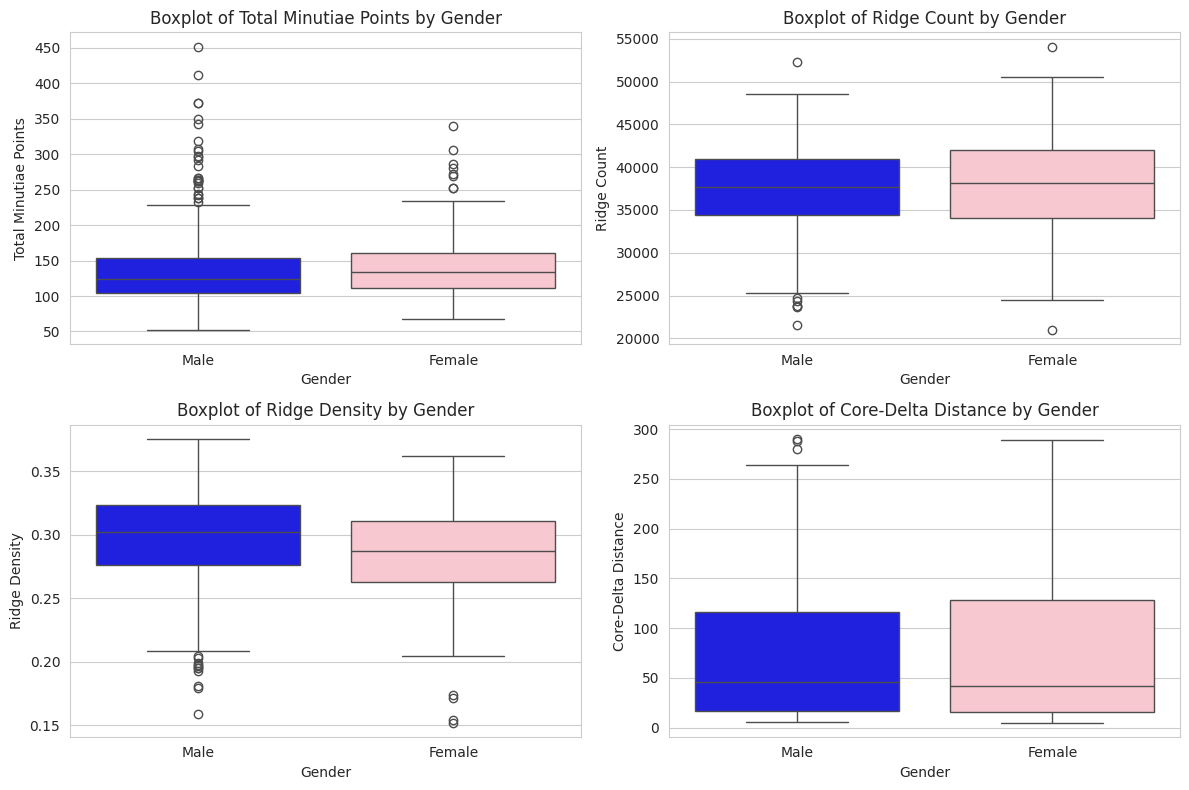

In [ ]:
sns.set_style("whitegrid")

# 1. Boxplots for Each Feature by Gender
plt.figure(figsize=(12, 8))
for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x="Gender", y=feature, data=df, palette=["blue", "pink"])
    plt.title(f"Boxplot of {feature} by Gender")
plt.tight_layout()
plt.show()


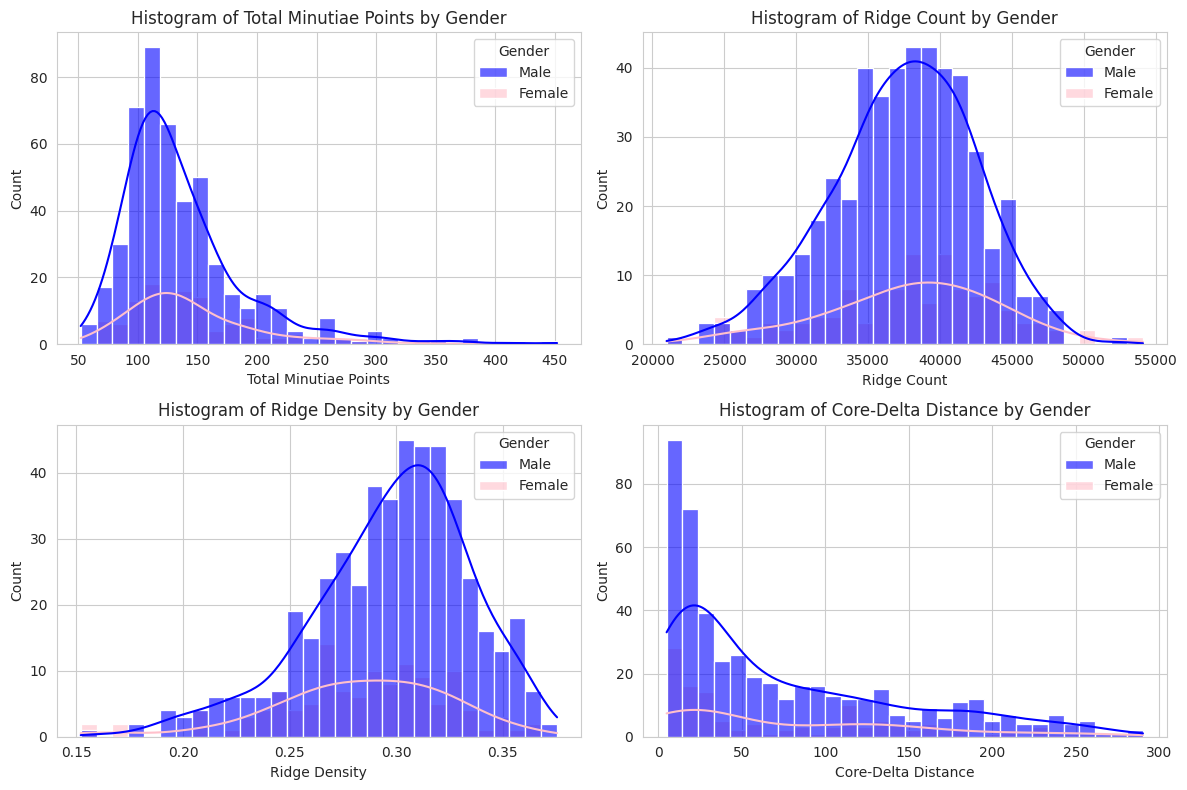

In [ ]:

plt.figure(figsize=(12, 8))
for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    sns.histplot(data=df, x=feature, hue="Gender", kde=True, bins=30, palette=["blue", "pink"], alpha=0.6)
    plt.title(f"Histogram of {feature} by Gender")
plt.tight_layout()
plt.show()


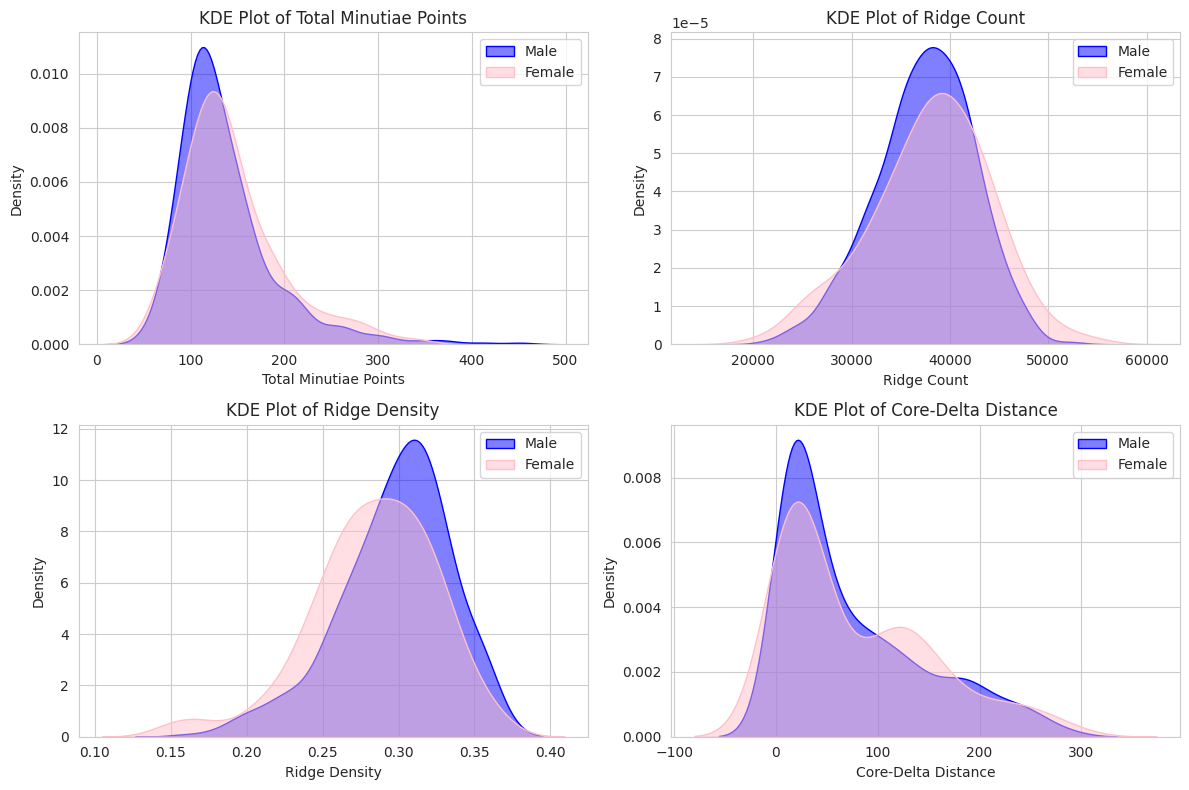

In [ ]:

plt.figure(figsize=(12, 8))
for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(male_df[feature], label="Male", fill=True, color="blue", alpha=0.5)
    sns.kdeplot(female_df[feature], label="Female", fill=True, color="pink", alpha=0.5)
    plt.title(f"KDE Plot of {feature}")
    plt.legend()
plt.tight_layout()
plt.show()


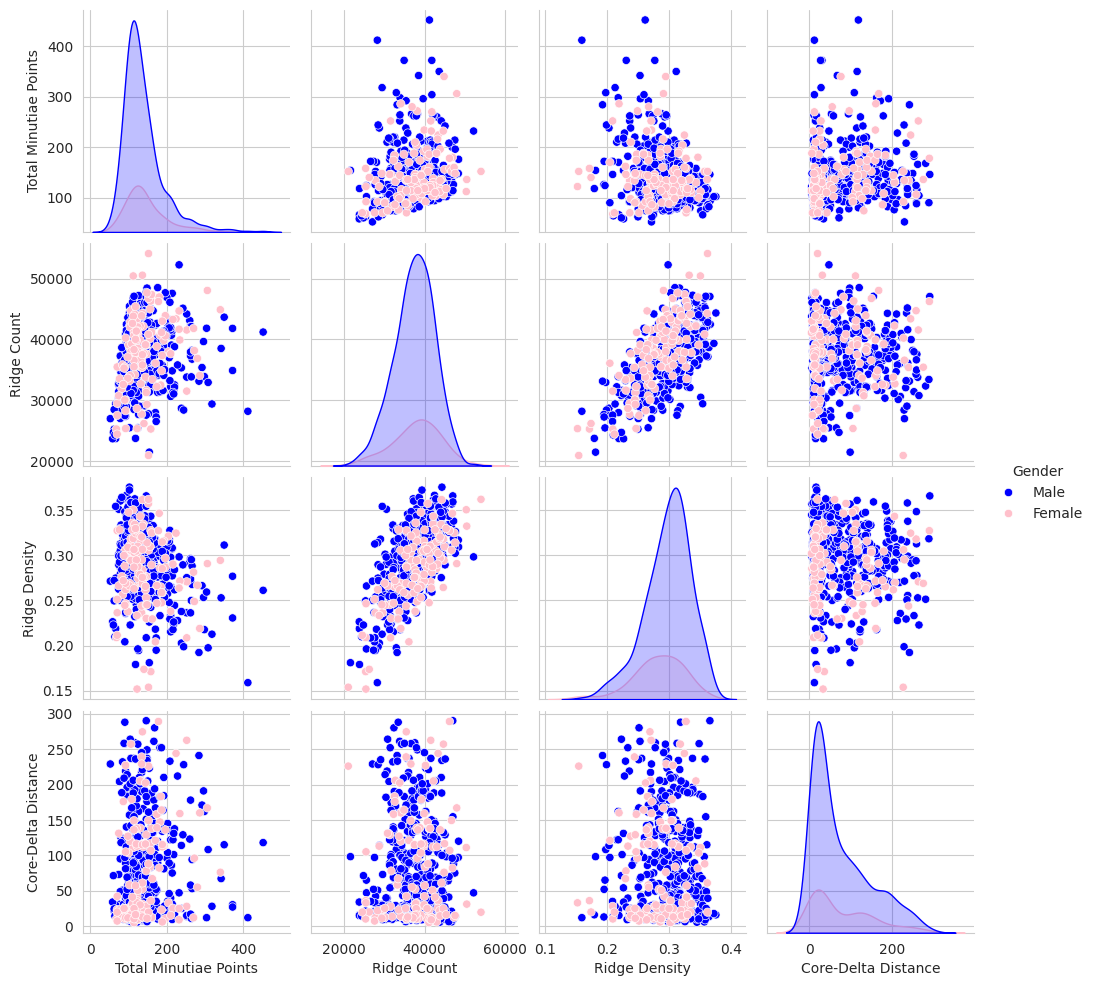

In [ ]:

sns.pairplot(df, hue="Gender", palette=["blue", "pink"])
plt.show()

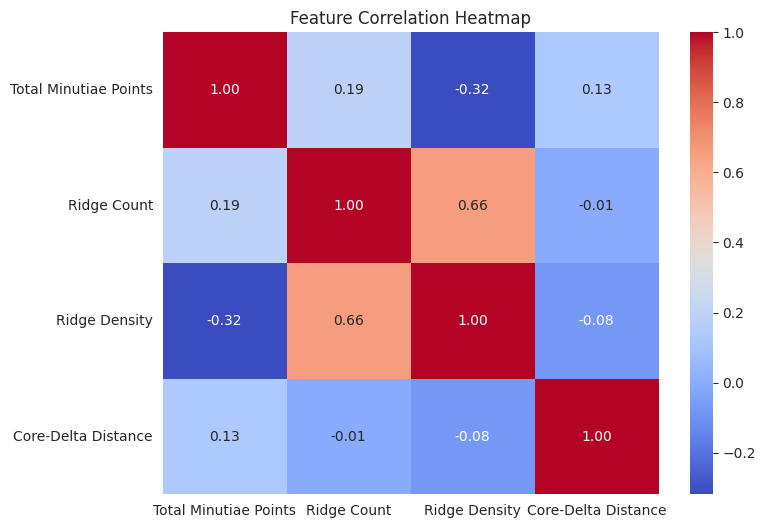

In [ ]:

plt.figure(figsize=(8, 6))
corr = df[features].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

### **Gender Differences in Fingerprint Features**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.multivariate.manova import MANOVA

# Load Data
df = pd.read_excel("/content/drive/MyDrive/Blood Group Detection/fingerprint_features_data.xlsx")

# Remove spaces from column names
df.columns = df.columns.str.strip()

# Rename columns
df = df.rename(columns={
    "Total Minutiae Points": "Total_Minutiae_Points",
    "Ridge Count": "Ridge_Count",
    "Ridge Density": "Ridge_Density",
    "Core-Delta Distance": "Core_Delta_Distance"
})

# Validate column existence
features = ["Total_Minutiae_Points", "Ridge_Count", "Ridge_Density", "Core_Delta_Distance"]
missing_cols = [col for col in features if col not in df.columns]

if missing_cols:
    raise KeyError(f"Missing Columns in DataFrame: {missing_cols}")

# Select features and target
X = df[features]
y = df["Gender"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create standardized DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=features)
X_scaled_df["Gender"] = y

# Perform MANOVA
formula = f"{' + '.join(features)} ~ Gender"
manova = MANOVA.from_formula(formula, data=X_scaled_df)
results = manova.mv_test()

# Extract MANOVA results
stat_table = results.results['Gender']['stat']

# Extract relevant values
manova_results = {
    "Test": ["Wilks' Lambda", "Pillai's Trace", "Hotelling-Lawley Trace", "Roy's Greatest Root"],
    "Value": stat_table["Value"].values,
    "Num DF": stat_table["Num DF"].values,
    "Den DF": stat_table["Den DF"].values,
    "F Value": stat_table["F Value"].values,
    "Pr > F": stat_table["Pr > F"].values,
}

# Convert to DataFrame
df_results = pd.DataFrame(manova_results)

# Decision Rule: Reject H0 if p-value < 0.05
alpha = 0.05
df_results["Decision"] = np.where(df_results["Pr > F"] < alpha, "Reject H₀", "Fail to Reject H₀")

# Display table
print("\n=== MANOVA Results ===\n")
print(df_results.to_string(index=False))



=== MANOVA Results ===

                  Test     Value Num DF Den DF    F Value Pr > F  Decision
         Wilks' Lambda   0.92506      4  595.0  12.050338    0.0 Reject H₀
        Pillai's Trace   0.07494    4.0  595.0  12.050338    0.0 Reject H₀
Hotelling-Lawley Trace  0.081011      4  595.0  12.050338    0.0 Reject H₀
   Roy's Greatest Root  0.081011      4    595  12.050338    0.0 Reject H₀


## **Hypothesis 2: Similarity Between Male and Female Fingerprint Patterns (Arch, Loop, Whorl)**

* **Null Hypothesis (H₀):** There is no difference in the distribution of fingerprint pattern types between males and females.

* **Alternate Hypothesis (H₁):**There is a significant difference in the distribution of fingerprint pattern types between males and females.



In [ ]:
print("\nChi-Square Test for Association Between Gender and Pattern Type:")

# Create a contingency table for Gender and Pattern Type
contingency_table = pd.crosstab(df['Gender'], df['Pattern Type'])

# Perform Chi-Square Test
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-value: {p_value}")

alpha = 0.05

if p_value < alpha:
    print("Reject H0: Significant association found between fingerprint pattern(Arch,Loop,Whorl) and gender.")
else:
    print("Fail to reject H0: No significant association found.")


Chi-Square Test for Association Between Gender and Pattern Type:
Chi-Square Statistic: 9.090859305833192
P-value: 0.0106156107081802
Reject H0: Significant association found between fingerprint pattern(Arch,Loop,Whorl) and gender.


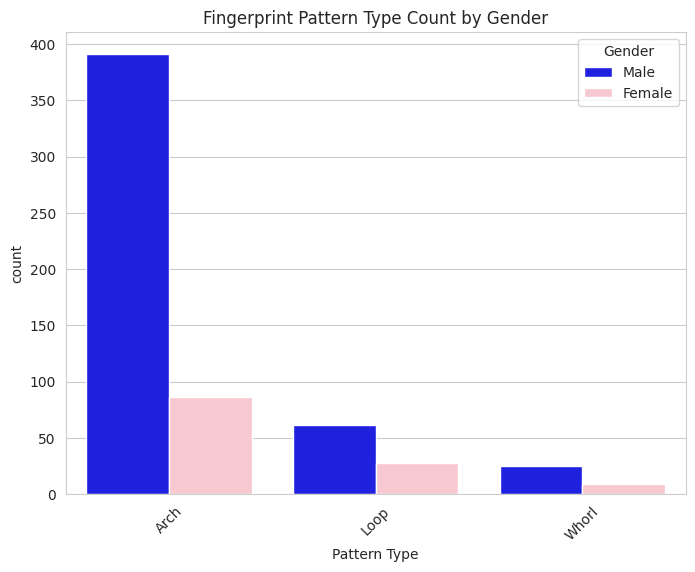

In [ ]:

plt.figure(figsize=(8, 6))
sns.countplot(x="Pattern Type", hue="Gender", data=df, palette=["blue", "pink"])
plt.title("Fingerprint Pattern Type Count by Gender")
plt.xticks(rotation=45)
plt.show()